In [2]:
import sys
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data.dataloader import default_collate
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch
import pickle

# Append the project dir to path
sys.path.append(os.path.join("..", "..", ".."))
from data_pipeline.utils import train_test_split, create_metadata_df, get_sample_weights_of_dataset, measurements_to_df
from data_pipeline.dataset_xy import CARLADatasetXY
from data_pipeline.dataset_xy_opt import CARLADatasetXYOpt
from data_pipeline.data_preprocessing import preprocessing
from models.resnet_baseline.architectures_v3 import Resnet_Baseline_V3
from models.model_trainer import ModelTrainer

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Choose training settings

In [3]:
# Set data balancing options (if both false, then no balancing is applied)
use_balance_by_loss_weighting = False
use_balance_by_over_under_sampling = True

assert not use_balance_by_loss_weighting or not use_balance_by_over_under_sampling

In [4]:
# Train additionally on the noisy data
use_data_noisy = True

path_data_noisy = None
if use_data_noisy:
    path_data_noisy = os.path.join("..", "..", "..", "data", "Noise-Dataset")

## Create Datasets

In [5]:
path_data = os.path.join("..", "..", "..", "data", "data")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
batch_size = 64

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])
df_meta_data_noisy = None
if use_data_noisy:
    df_meta_data_noisy = create_metadata_df(path_data_noisy, config_xy["used_inputs"])

# Train/test split
train_test_config = {
    "train": ['Town00', 'Town01', 'Town02', 'Town03', 'Town04', 'Town05', 'Town07', 'Town08', 'Town09', 'Town10'],
    "test": ['Town06']
}
df_meta_data_train, df_meta_data_test_1, df_meta_data_test_2 = train_test_split(df_meta_data, towns_intersect=train_test_config, df_meta_data_noisy=df_meta_data_noisy)

# Decrease train/test size for quick test run
#df_meta_data_train = df_meta_data_train.head(5 * batch_size)
#df_meta_data_test_1 = df_meta_data_test_1.head(5 * batch_size)

# Create Dataset & DataLoader
dataset_train = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data_train, config=config_xy)
dataset_test_1 = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data_test_1, config=config_xy)
dataset_test_2 = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data_test_2, config=config_xy)

Varying number files among input types: ../../../data/data/rl_dataset_23_11/Routes_clipped_Town05_rl_Seed0/clipped_Town05_rl_route30_11_23_17_42_15/lidar_trans


In [42]:
df_meta_data_train

,dir,rgb,measurements
0,../../../data/data/coke_dataset_23_11/Routes_S...,0000.png,0000.json
1,../../../data/data/coke_dataset_23_11/Routes_S...,0001.png,0001.json
2,../../../data/data/coke_dataset_23_11/Routes_S...,0002.png,0002.json
3,../../../data/data/coke_dataset_23_11/Routes_S...,0003.png,0003.json
4,../../../data/data/coke_dataset_23_11/Routes_S...,0004.png,0004.json
...,...,...,...
217370,../../../data/Noise-Dataset/Noise-Dataset2/Tow...,0035.png,0035.json
217371,../../../data/Noise-Dataset/Noise-Dataset2/Tow...,0036.png,0036.json
217372,../../../data/Noise-Dataset/Noise-Dataset2/Tow...,0037.png,0037.json
217373,../../../data/Noise-Dataset/Noise-Dataset2/Tow...,0038.png,0038.json


## Generate sample weights to be passed to ModelTrainer

In [43]:
def save_sample_weights(sample_weights):
    with open('sample_weights.pickle', 'wb') as handle:
        pickle.dump(sample_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_sample_weights():
    with open('sample_weights.pickle', 'rb') as handle:
        b = pickle.load(handle)
    return b

In [44]:
sample_weights = None
if use_balance_by_loss_weighting or use_balance_by_over_under_sampling:
    # Dictionary that saves all weights to all y variables 
    sample_weights = get_sample_weights_of_dataset(dataset_train, num_bins=10, multilabel_option=False) # TODO: Hacky False to try prob balacing only on steer
    # sample_weights = load_sample_weights()
    print(sample_weights.keys())

100%|██████████| 217375/217375 [01:26<00:00, 2527.14it/s]


dict_keys(['brake', 'steer', 'throttle'])


In [47]:
# TODO: Hacky False to try prob balacing only on steer
sample_weights = {"multilabel": sample_weights["steer"]}

## Create DataLoaders

In [50]:
df_meas_train = measurements_to_df(df_meta_data_train)
df_meas_train["probs"] = sample_weights["multilabel"]

100%|██████████| 217375/217375 [01:24<00:00, 2573.71it/s]


array([<AxesSubplot: title={'center': '1'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': '2'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': '3'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': '4'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': '5'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': '6'}, ylabel='Frequency'>],
      dtype=object)

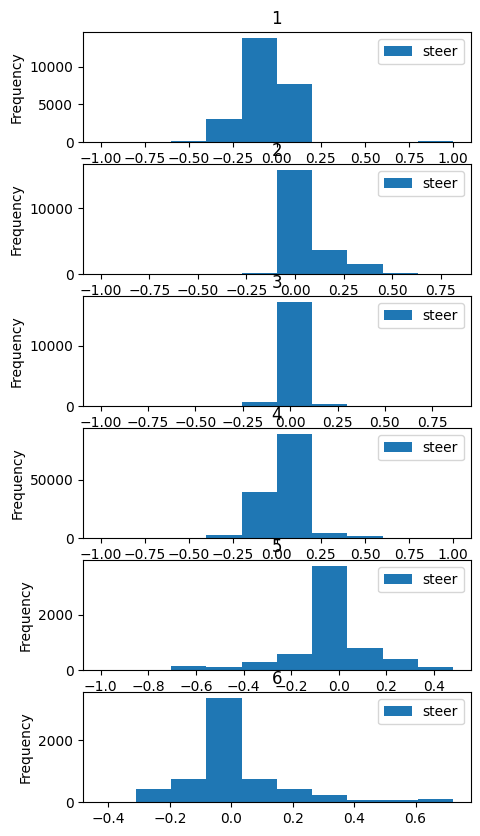

In [71]:
df_meas_train[["command", "steer"]].plot.hist(by="command", bins=10, figsize=(5, 10))

<AxesSubplot: xlabel='steer', ylabel='probs'>

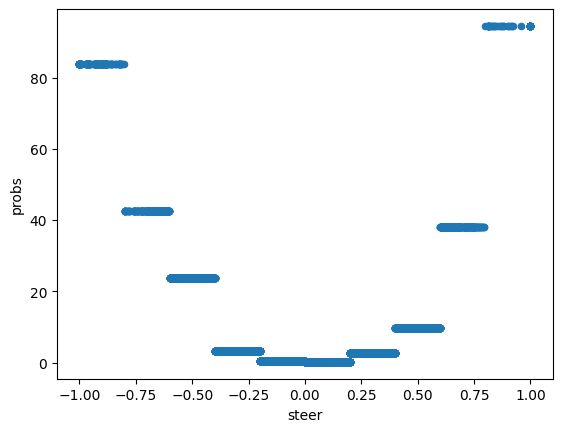

In [52]:
df_meas_train.plot.scatter(x="steer", y="probs")

In [53]:
weighted_random_sampler = None
shuffle = True
if use_balance_by_over_under_sampling:
    weighted_random_sampler = WeightedRandomSampler(weights=sample_weights["multilabel"], num_samples=dataset_train.__len__(), replacement=True)
    shuffle = False

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=0, shuffle=shuffle, sampler=weighted_random_sampler)
dataloader_test_1 = DataLoader(dataset_test_1, batch_size=batch_size, num_workers=0, shuffle=False, )
dataloader_test_2 = DataLoader(dataset_test_2, batch_size=batch_size, num_workers=0, shuffle=False, )

# Attempt to directly initialize tensors on device in the DataLoader
# collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))
# collate_fn=lambda x: list(map(lambda x: x.to(device), default_collate(x))

In [54]:
len(dataloader_train)

3397

In [55]:
len(dataloader_test_1)

271

# Create ModelTrainer & run it

In [60]:
model = Resnet_Baseline_V3()
#model.load_state_dict(torch.load("resnet_baseline_v3.pt"))

if not use_balance_by_loss_weighting:
    sample_weights = None

In [65]:
model = model_trainer.model.to(torch.device("cpu"))
torch.save(model.state_dict(), f"resnet_baseline_v3_6_10_epochs_prob_balanced_steer_only_noisy_2.pt".lower())

In [63]:
# Must be ordered alphabetically (i.e. the same like sample_weights keys)
loss_fns_dict = {"brake": nn.L1Loss(reduction='none'), "steer": nn.L1Loss(reduction='none'), "throttle": nn.L1Loss(reduction='none')}
loss_fn_weights = {"brake": 0.05, "steer": 0.45, "throttle": 0.5}

model_trainer = ModelTrainer(
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.0001),
    loss_fns=loss_fns_dict,
    loss_fn_weights=loss_fn_weights,
    n_epochs=10,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test_1,
    sample_weights=sample_weights,
    preprocessing=preprocessing,
    upload_tensorboard=True
    )

Model will be trained on: mps


In [64]:
model_trainer.run()

Epoch 1

Epoch [1/10], Step [0/3397], Loss: 0.4113
Epoch [1/10], Step [200/3397], Loss: 0.2067
Epoch [1/10], Step [400/3397], Loss: 0.2013
Epoch [1/10], Step [600/3397], Loss: 0.1730
Epoch [1/10], Step [800/3397], Loss: 0.1368
Epoch [1/10], Step [1000/3397], Loss: 0.1181
Epoch [1/10], Step [1200/3397], Loss: 0.1275
Epoch [1/10], Step [1400/3397], Loss: 0.1194
Epoch [1/10], Step [1600/3397], Loss: 0.1107
Epoch [1/10], Step [1800/3397], Loss: 0.0975
Epoch [1/10], Step [2000/3397], Loss: 0.1019
Epoch [1/10], Step [2200/3397], Loss: 0.1152
Epoch [1/10], Step [2400/3397], Loss: 0.0970
Epoch [1/10], Step [2600/3397], Loss: 0.0827
Epoch [1/10], Step [2800/3397], Loss: 0.0889
Epoch [1/10], Step [3000/3397], Loss: 0.1018
Epoch [1/10], Step [3200/3397], Loss: 0.0751

train-loss: 0.0404,
Validation Loss: 0.0613, 

Epoch took:  1:10:46
Epoch 2

Epoch [2/10], Step [0/3397], Loss: 0.0617
Epoch [2/10], Step [200/3397], Loss: 0.0868
Epoch [2/10], Step [400/3397], Loss: 0.0738
Epoch [2/10], Step [600/3

TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/GV8NLlARQ825IzGzmkJWpg/

[2023-02-10T04:30:54] Started scanning logdir.
[2023-02-10T04:30:55] Total uploaded: 60 scalars, 0 tensors, 0 binary objects
[2023-02-10T04:30:55] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/GV8NLlARQ825IzGzmkJWpg/


In [34]:
model_trainer.df_performance_stats[["val_brake_loss",	"val_steer_loss",	"val_throttle_loss"]].mean(axis=1)

0    0.059835
1    0.055580
2    0.054325
3    0.054581
4    0.051669
5    0.050750
6    0.048903
7    0.047978
8    0.042961
9    0.037833
dtype: float64

# Investigating model predictions (errors)
To be moved in an extra module at some time ...

In [ ]:
model = Baseline_V3()
model.load_state_dict(torch.load("baseline_v3_7_hours.pt"))

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [71]:
model = model_trainer.model.to(torch.device("cpu"))
torch.save(model.state_dict(), "resnet_baseline_v3_4_10_epochs_loss_balanced_noisy_2.pt")

In [ ]:
model_trainer = ModelTrainer(
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.0001),
    loss_fn=nn.L1Loss(),
    n_epochs=10,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    preprocessing=preprocessing,
    upload_tensorboard=True
    )

Model will be trained on: mps


In [ ]:
y_true_list, y_pred_list = model_trainer.get_dataset_predictions()

143it [02:30,  1.06s/it]


In [ ]:
df_true = pd.DataFrame(np.transpose(y_true_list), columns=dataset_test.y)
df_pred = pd.DataFrame(np.transpose(y_pred_list), columns=dataset_test.y)

array([[<AxesSubplot: title={'center': 'brake'}>,
        <AxesSubplot: title={'center': 'steer'}>],
       [<AxesSubplot: title={'center': 'throttle'}>, <AxesSubplot: >]],
      dtype=object)

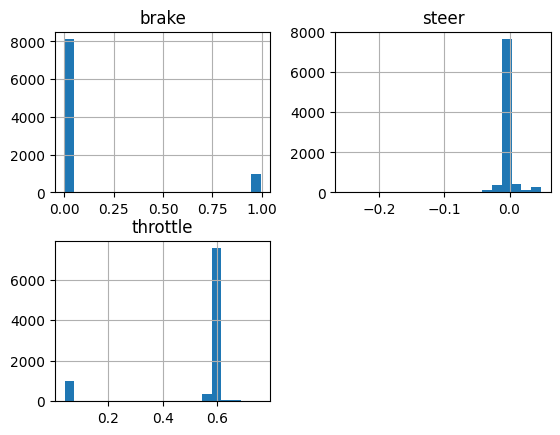

In [ ]:
df_pred.hist(bins=20)

In [ ]:
df_residuals = df_true - df_pred

array([[<AxesSubplot: title={'center': 'brake'}>,
        <AxesSubplot: title={'center': 'steer'}>],
       [<AxesSubplot: title={'center': 'throttle'}>, <AxesSubplot: >]],
      dtype=object)

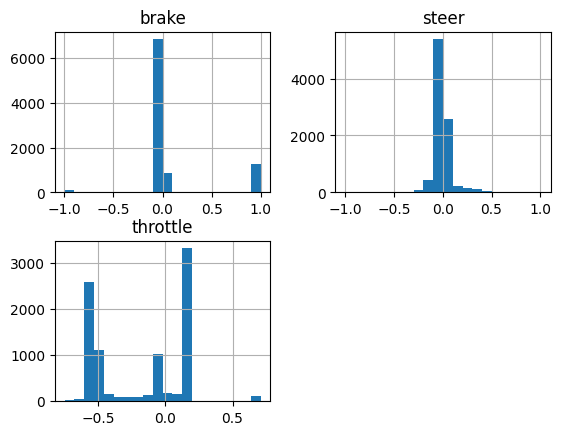

In [ ]:
df_residuals.hist(bins=20)

## Experiment which operators/function can be executed on device

In [ ]:
sum([torch.tensor([1, 2], device=torch.device("mps")), torch.tensor([1, 2], device=torch.device("mps"))])

tensor([2, 4], device='mps:0')

In [ ]:
# Preprocessing could be done on GPU but not on MPS (Apple)
preprocessing["rgb"](torch.rand((3, 160, 960), device=torch.device("mps")))

tensor([[[-1.5880, -1.5818, -1.5906,  ..., -1.5935, -1.5822, -1.5898],
         [-1.5930, -1.5885, -1.5856,  ..., -1.5849, -1.5842, -1.5823],
         [-1.5916, -1.5824, -1.5912,  ..., -1.5888, -1.5918, -1.5912],
         ...,
         [-1.5876, -1.5815, -1.5863,  ..., -1.5863, -1.5891, -1.5891],
         [-1.5907, -1.5873, -1.5811,  ..., -1.5932, -1.5911, -1.5855],
         [-1.5811, -1.5949, -1.5936,  ..., -1.5817, -1.5894, -1.5840]],

        [[-1.3437, -1.3457, -1.3556,  ..., -1.3549, -1.3420, -1.3563],
         [-1.3516, -1.3566, -1.3536,  ..., -1.3507, -1.3517, -1.3536],
         [-1.3434, -1.3525, -1.3566,  ..., -1.3443, -1.3414, -1.3515],
         ...,
         [-1.3487, -1.3424, -1.3464,  ..., -1.3550, -1.3503, -1.3463],
         [-1.3541, -1.3570, -1.3488,  ..., -1.3472, -1.3501, -1.3563],
         [-1.3416, -1.3412, -1.3502,  ..., -1.3461, -1.3422, -1.3530]],

        [[-1.1878, -1.1793, -1.1850,  ..., -1.1920, -1.1868, -1.1808],
         [-1.1811, -1.1790, -1.1906,  ..., -1

In [ ]:
torch.tensor([1, 2], device=torch.device("mps")).device

device(type='mps', index=0)

In [ ]:
test_dict = {"t1": torch.tensor([1, 2, 3])}
# [test_dict[key].to(torch.device("mps")) for key in test_dict]
for key in test_dict:
    test_dict[key] = test_dict[key].to(torch.device("mps"))

In [21]:
torch_values = torch.tensor([0, 1, 2, 3, 4], device=torch.device("mps"))
torch_IDX = torch.tensor([0, 2])

In [22]:
torch_values[torch_IDX]

tensor([0, 2], device='mps:0')

In [21]:
dirs = os.listdir("runs")
dirs_creation_time = [os.path.getctime(os.path.join("runs", dir)) for dir in dirs]


In [26]:
[el[0] for el in sorted(zip(dirs, dirs_creation_time), key=lambda x: x[1])][-1]

'Feb03_18-24-31_MBPvonJulian2.fritz.box'

In [19]:
os.path.getctime('runs/Feb03_15-22-49_MBPvonJulian2.fritz.box')

1675434169.053314